In [4]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [5]:
import numpy as np

from scipy.stats import norm, chi2
from scipy.optimize import curve_fit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import pickle

from tqdm import tqdm

from matplotlib import pyplot as plt

import params, utils
from models import mlp, gnn
from modules import helpers, training, fitting

In [6]:
import importlib

importlib.reload(params)
importlib.reload(utils)

importlib.reload(training)
importlib.reload(fitting)

importlib.reload(mlp)
importlib.reload(gnn)

<module 'models.gnn' from '/Users/vinhtran/Data/MIT Classes/Spring 2025/8.13/mit-jlab-sp25/higgs/analysis/models/gnn.py'>

In [7]:
helpers.set_plot_configs()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [8]:
MC_dir = '../HiggsTo4L/MC/'
data_dir = '../HiggsTo4L/data/'

In [9]:
four_leptons_data = utils.FourLeptonsData()
four_leptons_nn = utils.FourLeptonNN()

In [10]:
print('Higgs:')
mc_higgs_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'higgs2011.csv',
            MC_dir + 'higgs2012.csv'
        ]
    ],
    inv_mass_cut=None,
    show_cut_info=True
)

print('ZZ:')
mc_zz_all_data = four_leptons_data.apply_basic_cuts(
    [ 
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'zzto4mu2011.csv',
            MC_dir + 'zzto2mu2e2011.csv',
            MC_dir + 'zzto4e2011.csv',

            MC_dir + 'zzto4mu2012.csv',
            MC_dir + 'zzto2mu2e2012.csv',
            MC_dir + 'zzto4e2012.csv',
        ]
    ],
    inv_mass_cut=None,
    show_cut_info=True
)

print('Drell-Yan:')
mc_dy_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'dy1050_2011.csv',
            MC_dir + 'dy50_2011.csv',
            MC_dir + 'dy1050_2012.csv',
            MC_dir + 'dy50_2012.csv'
        ]
    ],
    inv_mass_cut=None,
    show_cut_info=True
)

print('tt:')
mc_tt_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'ttbar2011.csv',
            MC_dir + 'ttbar2012.csv'
        ]
    ],
    inv_mass_cut=None,
    show_cut_info=True
)

Higgs:
 Conservation cut: 50542 events passed out of 52248 (97%)
 Leptons cut: 44320 events passed out of 50542 (88%)
 Z cut: 41818 events passed out of 44320 (94%)
 Conservation cut: 39353 events passed out of 40530 (97%)
 Leptons cut: 35855 events passed out of 39353 (91%)
 Z cut: 33996 events passed out of 35855 (95%)
ZZ:
 Conservation cut: 207439 events passed out of 209504 (99%)
 Leptons cut: 162016 events passed out of 207439 (78%)
 Z cut: 123286 events passed out of 162016 (76%)
 Conservation cut: 152367 events passed out of 155454 (98%)
 Leptons cut: 110224 events passed out of 152367 (72%)
 Z cut: 68099 events passed out of 110224 (62%)
 Conservation cut: 140811 events passed out of 144999 (97%)
 Leptons cut: 93161 events passed out of 140811 (66%)
 Z cut: 78064 events passed out of 93161 (84%)
 Conservation cut: 182153 events passed out of 183843 (99%)
 Leptons cut: 148678 events passed out of 182153 (82%)
 Z cut: 116017 events passed out of 148678 (78%)
 Conservation cut: 12

In [11]:
bins = np.linspace(50,200,51)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

higgs_hist = four_leptons_data.get_histogram(mc_higgs_all_data, params.scales_higgs, 'm4l', bins) 
zz_hist = four_leptons_data.get_histogram(mc_zz_all_data, params.scales_zz, 'm4l', bins)
dy_hist = four_leptons_data.get_histogram(mc_dy_all_data, params.scales_dy, 'm4l', bins)
tt_hist = four_leptons_data.get_histogram(mc_tt_all_data, params.scales_tt, 'm4l', bins)

2.0368169818683426
6.073385224375813


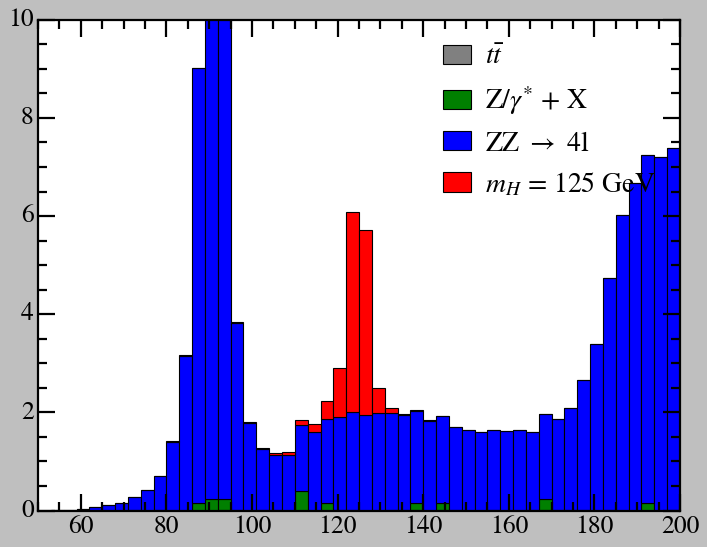

In [12]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)
stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red', bottom=tt_hist+dy_hist+zz_hist)

peak_higgs_bin = np.argmax(higgs_hist)
print(higgs_hist[peak_higgs_bin]/zz_hist[peak_higgs_bin])
print(higgs_hist[peak_higgs_bin]+zz_hist[peak_higgs_bin])

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

ax.set_xlim(50,200)
ax.set_ylim(0, 10)

plt.tight_layout()
plt.show()

In [13]:
all_higgs_and_zz_data = [
    four_leptons_data.read_data(file) for file in [
        MC_dir + 'higgs2011.csv',
        MC_dir + 'higgs2012.csv',

        MC_dir + 'zzto4mu2011.csv',
        MC_dir + 'zzto2mu2e2011.csv',
        MC_dir + 'zzto4e2011.csv',
        MC_dir + 'zzto4mu2012.csv',
        MC_dir + 'zzto2mu2e2012.csv',
        MC_dir + 'zzto4e2012.csv',
    ]
]

all_higgs_and_zz_data = four_leptons_data.apply_basic_cuts(
    all_higgs_and_zz_data,
    inv_mass_cut=None,
    show_cut_info=False
)

fields = [
    'PID1', 'px1', 'py1',
    'PID2', 'px2', 'py2',
    'PID3', 'px3', 'py3',
    'PID4', 'px4', 'py4',
]

test_ratio = 0.1

higgs_and_zz_train_loader, higgs_and_zz_val_loader, higgs_and_zz_test_datasets, higgs_and_zz_test_indices, N_trainval, N_test = four_leptons_nn.get_dataloaders(
    all_data = all_higgs_and_zz_data, data_labels = [1]*2 + [0]*6, fields = fields,
    test_ratio = test_ratio, train_ratio=0.8,
    balance_categories = True,
    batch_size=2048,num_workers=8,
    seed=42,
)

In [14]:
print('Training dataset size:', N_trainval)
print('Test dataset size:', N_test)

Training dataset size: 136468
Test dataset size: 59259


In [15]:
# model = mlp.BaseMLP(
#     lepton_dim = 8,
#     hidden_dims = [256, 64, 16, 4],
#     output_dim = 1,
#     dropout = 0.0,
#     activation = nn.ReLU(),
#     norm = nn.BatchNorm1d,
#     last_activation = nn.Sigmoid(),
# )

model = mlp.LeptonMLP(
    lepton_dim = 3,
    pid_embedding_dim = 1,
    hidden_lepton_dims = [32, 32, 32],
    hidden_mpl_dims = [256, 64, 16, 4],
    output_dim = 1,
    dropout = 0.0,
    activation = nn.ReLU(),
    norm = nn.BatchNorm1d,
    last_activation = nn.Sigmoid(),
)

# model = gnn.LeptonGNN(
#     lepton_dim = 3,
#     pid_embedding_dim = 1,
#     hidden_lepton_dims = [128,64,],
#     hidden_gnn_args = {
#         'input_dim' : [32,32,32],
#         'hidden_node_dims' : [[64,16],[64,16],[64,16]],
#         'hidden_message_dims' : [[64,16],[64,16],[64,16]],
#         'hidden_feedforward_dims' : [[64,32],[64,32],[64,32]],
#     },
#     hidden_mpl_dims = [64, 16, 4],
#     output_dim = 1,
#     dropout = 0.0,
#     activation = nn.ReLU(),
#     norm = nn.BatchNorm1d,
#     last_activation = nn.Sigmoid(),
# )

In [16]:
trainer = training.SupervisedTraining(
    model=model,
    train_loader=higgs_and_zz_train_loader,
    val_loader=higgs_and_zz_val_loader,
    num_epochs=50,
    lr=3e-3,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam,
    scheduler=optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={'T_max': 50},
    is_classification=True,
    num_classes=2,
    device='mps',
)

In [17]:
# trainer.train(save_training_stats_every=5, save_model_every=None, outpath='training_result/lepton_gnn_limited_mass_extended/')

In [18]:
training_stats = pickle.load(open('training_result/lepton_mlp_limited_mass_pT_and_ID/training_stats.pkl', 'rb'))

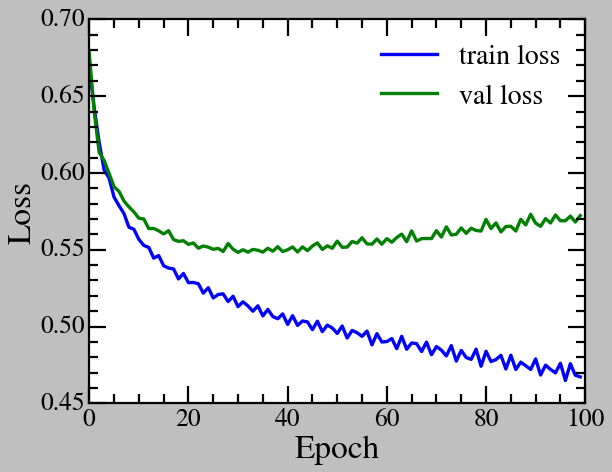

In [19]:
plt.plot(training_stats['train_losses'], label='train loss')
plt.plot(training_stats['val_losses'], label='val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

#plt.yscale('log')


plt.legend()
plt.savefig('../report/Figures/training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

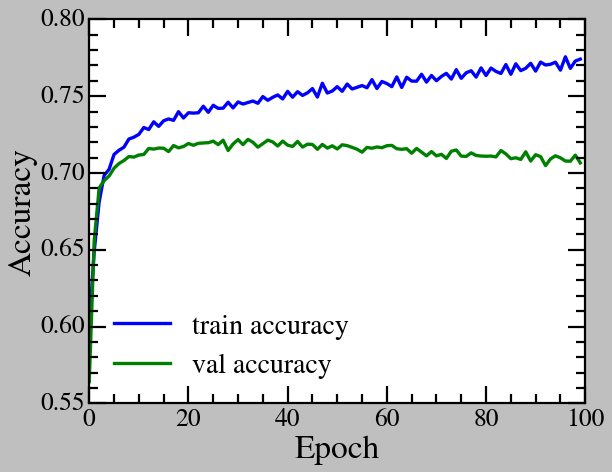

In [20]:
plt.plot(training_stats['train_accuracies'], label='train accuracy')
plt.plot(training_stats['val_accuracies'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.savefig('../report/Figures/training_accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

In [21]:
best_model_idx = np.argmin(training_stats['val_losses'])

print('Best detection rate:', training_stats['val_P_detections'][best_model_idx])
print('Best false alarm rate:', training_stats['val_P_false_alarms'][best_model_idx])

Best detection rate: 0.772425039248033
Best false alarm rate: 0.3290171541950919


In [22]:
best_state_dict = torch.load('training_result/lepton_mlp_limited_mass_pT_and_ID/model/best.pth')['model_state_dict']
model.load_state_dict(best_state_dict)

/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_81761/1874239265.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load('training_result

<All keys matched successfully>

In [23]:
nn_higgs_and_zz_data = four_leptons_nn.apply_nn_cut(
    all_higgs_and_zz_data,
    higgs_and_zz_test_datasets, higgs_and_zz_test_indices,
    model,threshold=0.5, device='mps'
)

nn_higgs_data = nn_higgs_and_zz_data[:2]
nn_zz_data = nn_higgs_and_zz_data[2:]

In [24]:
bins = np.linspace(70,180,36)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

nn_higgs_hist = 1/test_ratio*four_leptons_data.get_histogram(nn_higgs_data, params.scales_higgs, 'm4l', bins) 
nn_zz_hist = 1/test_ratio*four_leptons_data.get_histogram(nn_zz_data, params.scales_zz, 'm4l', bins)

5.136744089733433
5.488906540181335


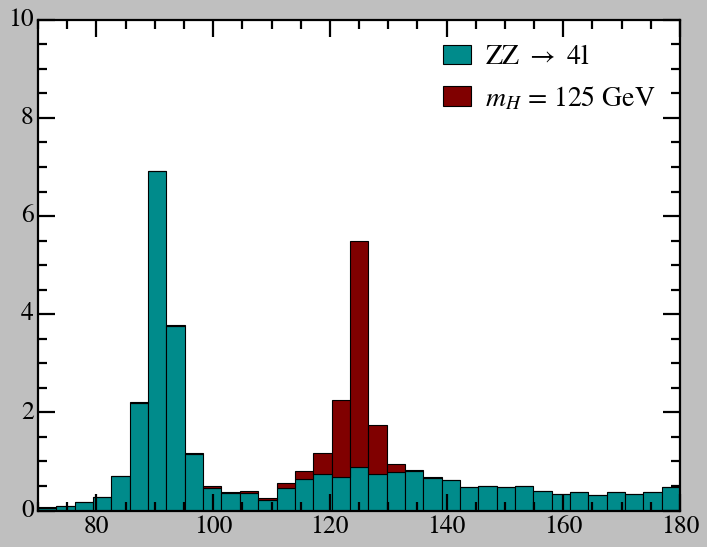

In [25]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, nn_zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='darkcyan')
stack = ax.bar(bin_centers, nn_higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='maroon', bottom=nn_zz_hist)

peak_higgs_bin = np.argmax(nn_higgs_hist)
print(nn_higgs_hist[peak_higgs_bin]/nn_zz_hist[peak_higgs_bin])
print(nn_higgs_hist[peak_higgs_bin]+nn_zz_hist[peak_higgs_bin])

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

ax.set_xlim(70,180)
ax.set_ylim(0, 10)

plt.tight_layout()
plt.show()

In [26]:
all_observed_data = [
    four_leptons_data.read_data(file) for file in [
        data_dir + 'clean_data_2011.csv',
        data_dir + 'clean_data_2012.csv',
    ]
]

all_observed_data = four_leptons_data.apply_basic_cuts(
    all_observed_data,
    inv_mass_cut=None,
    show_cut_info=False
)

fields = [
    'PID1', 'px1', 'py1',
    'PID2', 'px2', 'py2',
    'PID3', 'px3', 'py3',
    'PID4', 'px4', 'py4',
]


observed_dataloaders = [
    DataLoader(
        TensorDataset(torch.tensor(data[:,[params.field_indices[field] for field in fields]],dtype=torch.float32)),
        batch_size = 2048, num_workers = 8, shuffle = False,
    ) for data in all_observed_data
]

observed_indices = [
    np.arange(data.shape[0]) for data in all_observed_data
]

In [27]:
nn_observed_data = four_leptons_nn.apply_nn_cut(
    all_observed_data,
    observed_dataloaders, observed_indices,
    model,threshold=0.5, device='mps'
)

In [28]:
nn_observed_hist = four_leptons_data.get_histogram(nn_observed_data, params.scales_data, 'm4l', bins) 

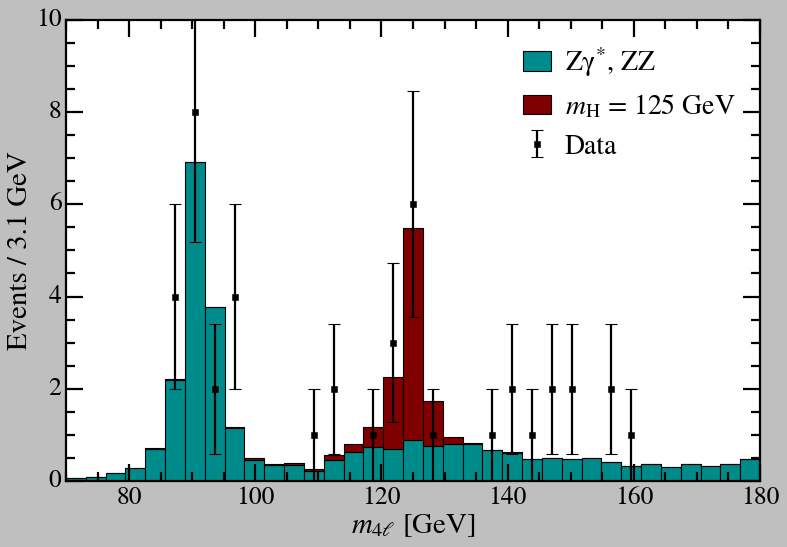

In [29]:
fig, ax = plt.subplots(figsize=(10,7))

stack = ax.bar(bin_centers, nn_zz_hist, align='center', width=bin_width, label=r'Z$\rm \gamma^{*}$, ZZ', color='darkcyan')
stack = ax.bar(bin_centers, nn_higgs_hist, align='center', width=bin_width, label=r'$m_{\rm H}$ = 125 GeV', color='maroon', bottom=nn_zz_hist)

mask = nn_observed_hist > 0
ax.errorbar(bin_centers[mask],nn_observed_hist[mask],yerr=np.sqrt(nn_observed_hist[mask]),
            fmt=' s', markersize=5, elinewidth=2, capsize=5, capthick=1, 
            color='black',label='Data')

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

ax.set_xlim(70,180)
ax.set_ylim(0, 10)

ax.set_xlabel(r'$m_{4 \ell}$ [GeV]',fontsize=26)
ax.set_ylabel(f'Events / {bin_width:.01f} GeV',fontsize=26)

plt.tight_layout()
plt.savefig('event_histogram.png')

plt.show()

In [30]:
def f_ZZ(bin_indices, b):
    return b / np.sum(nn_zz_hist) * nn_zz_hist[bin_indices]

def f_Higgs(bin_indices, s, mH, sigma_mH):
    P_Higgs = norm.cdf(bins,loc=mH,scale=sigma_mH)
    return s * np.diff(P_Higgs)[bin_indices]

In [31]:
b = np.sum(nn_zz_hist)
sigma_mH = 1.2

In [32]:
class ZZFitter(fitting.BasePoissonFitter):
    def __init__(self,
                 bin_indices=np.arange(bin_centers.shape[0]),
                 counts=nn_observed_hist,
                 b=None):
        super().__init__(bin_indices,counts)

        self.b = b

    def _get_initial_guess(self):
        return [60]
    
    def _get_model(self, x, params):
        b = params[0]

        if self.b:
            b = self.b

        return f_ZZ(x,b)
    
class HiggsFitter(fitting.BasePoissonFitter):
    def __init__(self,
                 bin_indices=np.arange(bin_centers.shape[0]),
                 counts=nn_observed_hist,
                 b=None,
                 mH=None,
                 sigma_mH=None):
        super().__init__(bin_indices,counts)

        self.b = b
        self.mH = mH
        self.sigma_mH = sigma_mH

    def _get_initial_guess(self):
        return [50,10,125,1]
    
    def _get_model(self, x, params):
        b, s, mH, sigma_mH = params

        if self.b:
            b = self.b
        if self.mH:
            mH = self.mH
        if self.sigma_mH:
            sigma_mH = self.sigma_mH

        return f_ZZ(x,b) + f_Higgs(x,s,mH,sigma_mH)

In [33]:
zz_fitter = ZZFitter()
zz_fitting_result = zz_fitter.fit()
print(zz_fitting_result)

{'params': array([58.00347435]), 'e_params': array([9.7812229]), 'chisqr': 24.266754151225708, 'reduced_chisqr': 1.5166721344516068, 'alpha': 0.08383802931531059, 'cov': array([[95.67232148]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


In [34]:
higgs_fitter = HiggsFitter(sigma_mH=0.4)
higgs_fitting_result = higgs_fitter.fit()
print(higgs_fitting_result)

{'params': array([ 49.60560069,   6.25517713, 123.65151722,   1.        ]), 'e_params': None, 'chisqr': 15.993853705898738, 'reduced_chisqr': 1.2302964389152875, 'alpha': 0.24946190726075945, 'cov': None, 'success': True, 'message': '`ftol` termination condition is satisfied.'}


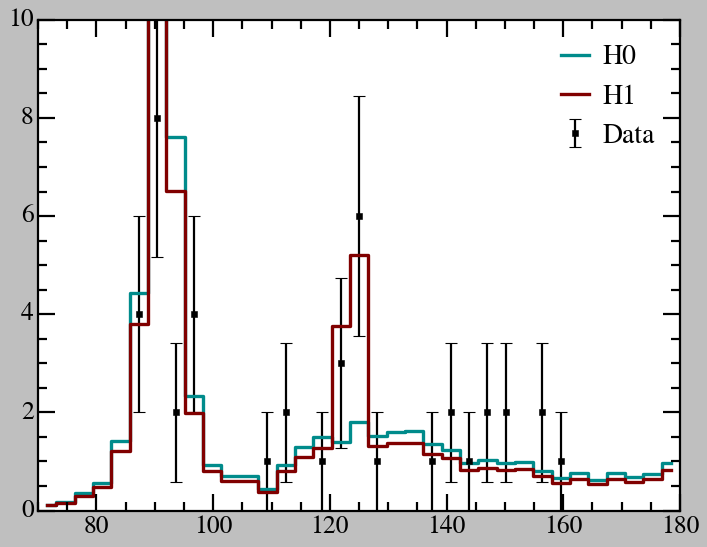

In [35]:
if True:
    fig, ax = plt.subplots(figsize=(9,7))

    mask = nn_observed_hist > 0
    ax.errorbar(bin_centers[mask],nn_observed_hist[mask],yerr=np.sqrt(nn_observed_hist[mask]),
                fmt=' s', markersize=5, elinewidth=2, capsize=5, capthick=1, 
                color='black',label='Data')

    zz_inferred_counts = f_ZZ(np.arange(bin_centers.shape[0]),zz_fitting_result['params'][0])
    higgs_inferred_counts = f_ZZ(np.arange(bin_centers.shape[0]),higgs_fitting_result['params'][0]) + f_Higgs(np.arange(bin_centers.shape[0]),*higgs_fitting_result['params'][1:])

    ax.plot(bin_centers, zz_inferred_counts, drawstyle='steps-mid', color='darkcyan', label='H0')
    ax.plot(bin_centers, higgs_inferred_counts, drawstyle='steps-mid', color='maroon', label='H1')

    ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

    ax.set_xlim(70,180)
    ax.set_ylim(0, 10)

    plt.tight_layout()
    plt.savefig('../report/Figures/hypo_testing.png', dpi=300, bbox_inches='tight')
    plt.show()

In [36]:
delta_chisqr = zz_fitting_result['chisqr'] - higgs_fitting_result['chisqr']
p_value = 1 - chi2.cdf(delta_chisqr,3)
z_score = - norm.ppf(p_value/2)
print('p-value:',f'{p_value:.02e}')
print('z-score:',f'{z_score:.02f}')

p-value: 4.07e-02
z-score: 2.05


In [37]:
class HiggMassFitter:
    def __init__(self,
                 bin_indices=np.arange(bin_centers.shape[0]),
                 counts=nn_observed_hist,
                 b=None,
                 sigma_mH=None,
                 mass_bins=np.linspace(110,160,1000)):
        
        self.bin_indices = bin_indices
        self.counts = counts

        self.b = b
        self.sigma_mH = sigma_mH
        self.mass_bins = mass_bins

        self.p_values = []
        self.z_scores = []
        for mH in tqdm(self.mass_bins):
            p_value, z_score = self._fit_single_mass(mH)

            self.p_values.append(p_value)
            self.z_scores.append(z_score)

    def _fit_single_mass(self,mH):
        zz_fitter = ZZFitter(
            self.bin_indices,
            self.counts,
            self.b,
        )

        higgs_fitter = HiggsFitter(
            self.bin_indices,
            self.counts,
            self.b,
            mH,
            self.sigma_mH,
        )

        delta_chisqr = zz_fitter.fit()['chisqr'] - higgs_fitter.fit()['chisqr']
        p_value = 1 - chi2.cdf(delta_chisqr,2)
        z_score = - norm.ppf(p_value/2)

        return p_value, z_score

In [38]:
higgs_mass_fitter = HiggMassFitter()

100%|██████████| 1000/1000 [00:21<00:00, 47.14it/s]


3.019387719067317


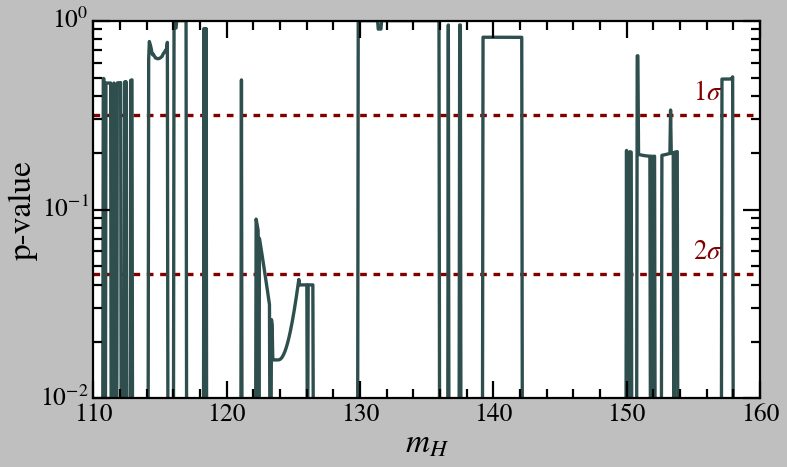

In [39]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(higgs_mass_fitter.mass_bins,higgs_mass_fitter.p_values,color='darkslategrey',zorder=-1)
print(np.max(- norm.ppf(np.array(higgs_mass_fitter.p_values)/2)))

for i in range(1,3):
    p_value = 2*norm.cdf(-i)
    ax.axhline(p_value,ls='--',color='maroon',zorder=-2)
    ax.text(155, 1.3*p_value, rf"${i}\sigma$", fontsize=24, rotation=0, horizontalalignment='left', verticalalignment='center', color='maroon')

ax.set_yscale('log')

ax.set_xlim(110,160)
ax.set_ylim(1e-2,1e0)

ax.set_xlabel(r'$m_H$')
ax.set_ylabel('p-value')

plt.tight_layout()
# plt.savefig('p-value.png')

plt.show()

In [58]:
class HiggMassFitter:
    def __init__(self,
                 bin_indices=np.arange(bin_centers.shape[0]),
                 counts=nn_observed_hist,
                 mH_bins=np.linspace(110,140,1201),
                 sigma_mH_bins=np.linspace(0.025,3,120)):
        
        self.bin_indices = bin_indices
        self.counts = counts

        self.mH_bins = mH_bins
        self.sigma_mH_bins = sigma_mH_bins

        self.p_values = np.ones((len(self.sigma_mH_bins),len(self.mH_bins)))

        for j,mH in enumerate(tqdm(self.mH_bins)):
            for i,sigma_mH in enumerate(self.sigma_mH_bins):
                p_value = self._fit_single_mass_single_width(mH,sigma_mH)

                self.p_values[i,j] = p_value

    def _fit_single_mass_single_width(self,mH,sigma_mH):
        zz_fitter = ZZFitter(
            self.bin_indices,self.counts,
        )

        higgs_fitter = HiggsFitter(
            self.bin_indices,self.counts,
            mH=mH,sigma_mH=sigma_mH,
        )

        delta_chisqr = zz_fitter.fit()['chisqr'] - higgs_fitter.fit()['chisqr']
        p_value = 1 - chi2.cdf(delta_chisqr,2)

        return p_value

In [59]:
higgs_mass_fitter = HiggMassFitter()

100%|██████████| 1201/1201 [1:15:50<00:00,  3.79s/it]   


In [60]:
print(- norm.ppf(np.min(higgs_mass_fitter.p_values)/2))

2.409388509641175


ValueError: x and y must have same first dimension, but have shapes (1201,) and (120, 1201)

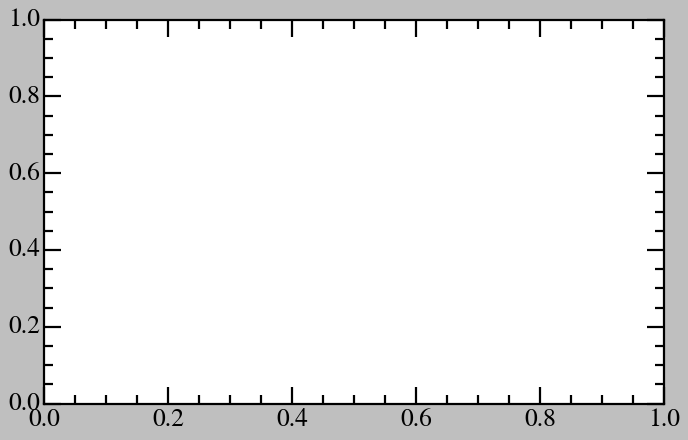

In [61]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(higgs_mass_fitter.mH_bins,higgs_mass_fitter.p_values,color='darkslategrey',zorder=-1)

for i in range(1,3):
    p_value = 2*norm.cdf(-i)
    ax.axhline(p_value,ls='--',color='maroon',zorder=-2)
    ax.text(135, 1.3*p_value, rf"${i}\sigma$", fontsize=24, rotation=0, horizontalalignment='left', verticalalignment='center', color='maroon')

ax.set_yscale('log')

ax.set_xlim(110,140)
ax.set_ylim(1e-2,1e0)

ax.set_xlabel(r'$m_H$')
ax.set_ylabel('p-value')

plt.tight_layout()
plt.savefig('p-value.png')

plt.show()

123.75


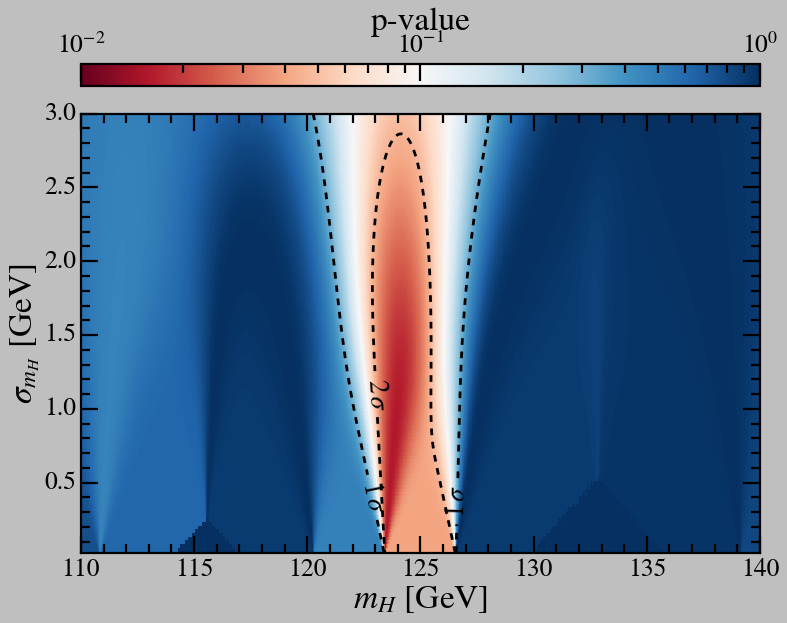

In [65]:
from matplotlib.colors import LogNorm

mH_grid,sigma_mH_grid = np.meshgrid(higgs_mass_fitter.mH_bins,higgs_mass_fitter.sigma_mH_bins)

fig, ax = plt.subplots(figsize=(10,8))

c = ax.pcolor(
    mH_grid, sigma_mH_grid, higgs_mass_fitter.p_values,
    cmap='RdBu', norm=LogNorm(vmin=1e-2, vmax=1)
)
cb = fig.colorbar(c, ax=ax, ticks=[1e-2,1e-1,1e0], location='top', aspect=30) #format=r'$10^{%.0f}$'
cb.set_label('p-value')

con = ax.contour(
    mH_grid, sigma_mH_grid, - norm.ppf(higgs_mass_fitter.p_values/2),
    levels=[1,2],colors='black',linewidths=2.5,linestyles='--',
)
plt.clabel(con, inline=True, fmt=r'$%.0f \, \sigma$', fontsize=24, use_clabeltext=True)

print(mH_grid.flatten()[np.argmin(higgs_mass_fitter.p_values)])

ax.set_xlim(110,140)
ax.set_ylim(0.025,3)

ax.set_xlabel(r'$m_H$ [GeV]')
ax.set_ylabel(r'$\sigma_{m_H}$ [GeV]')

plt.tight_layout()
plt.savefig('p-value.png')

plt.show()

In [ ]:
class HiggsBoot:
    def __init__(self,bin_indices, nn_observed_hist, n_MC=1000):
        mask = nn_observed_hist > 0

        self.bin_indices = bin_indices[mask]
        self.nn_observed_hist = nn_observed_hist[mask]

        self.mHs = []
        for i in tqdm(range(n_MC)):
            mH = self._bootstrap()

            self.mHs.append(mH)

            with open('bootstrap_results.pkl', 'wb') as f:
                pickle.dump(self.mHs, f)

    def _bootstrap(self):
        fitter = HiggMassFitter(
            bin_indices=self.bin_indices,
            counts=np.random.poisson(self.nn_observed_hist),
            mH_bins=np.linspace(110,140,601),
            sigma_mH_bins=[1.2],
        )
        mH_grid, _ = np.meshgrid(fitter.mH_bins,fitter.sigma_mH_bins)

        return mH_grid.flatten()[np.argmin(fitter.p_values)]

In [ ]:
# higgs_boot = HiggsBoot(np.arange(bin_centers.shape[0]), nn_observed_hist, n_MC=1000)

100%|██████████| 1000/1000 [2:09:33<00:00,  7.77s/it] 


124.2166666626147
1.1612149408653374


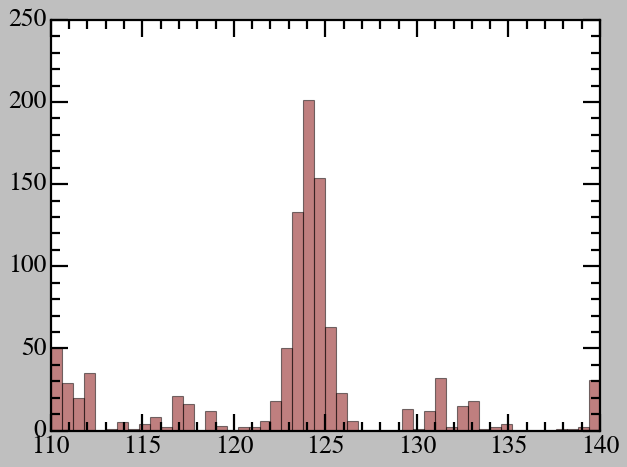

In [ ]:
# mHs = np.array(higgs_boot.mHs)
with open('bootstrap_results.pkl', 'rb') as f:
    mHs = np.array(pickle.load(f))

plt.hist(mHs, bins=50, density=False, alpha=0.5, color='maroon', label='Bootstrap mH')

gaussian_fitter = fitting.BayesianGaussian(mHs[np.logical_and(mHs>120,mHs<130)])
print(gaussian_fitter.mu)
print(gaussian_fitter.sigma)

plt.tight_layout()
plt.show()